!pip install tensorflow==2.16.1

In [1]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2024-05-18 09:40:09.335509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 09:40:09.335699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 09:40:09.510709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
3.2.1


# Finding the highest number image from patient directory and mapping it to train_label.csv and loading dicom images.

In [2]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd

def load_dicom_image(filepath):
    """Load a DICOM image, resize it to 256x256 pixels, and normalize its intensity."""
    try:
        ds = pydicom.dcmread(filepath)
        if hasattr(ds, 'pixel_array'):
            img = ds.pixel_array
            img = cv2.resize(img, (256, 256))
            img = (img / np.max(img) * 255).astype(np.uint8)
            return img
        else:
            return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def find_highest_numbered_image(patient_dir):
    """Find the five highest numbered images for each image type in the patient's directory."""
    image_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    highest_numbers = {}
    for image_type in image_types:
        image_files = []
        for root, dirs, files in os.walk(os.path.join(patient_dir, image_type)):
            for file in files:
                if file.endswith(".dcm"):
                    try:
                        # Extract the image number from the filename
                        image_number = int(file.split('.')[0].split('-')[1])
                        image_files.append(image_number)
                    except Exception as e:
                        print(f"Error processing file {file}: {e}")
        if image_files:
            highest_numbers[image_type] = sorted(image_files, reverse=True)[:5]
    return highest_numbers

def load_and_store_highest_images(dataset_dir):
    """Load and store the paths of the highest numbered images for each patient."""
    highest_images = {}
    for patient_dir in os.listdir(dataset_dir):
        patient_id = patient_dir
        patient_path = os.path.join(dataset_dir, patient_dir)
        highest_numbers = find_highest_numbered_image(patient_path)
        if highest_numbers:
            highest_images[patient_id] = highest_numbers
    return highest_images

def load_highest_images(highest_images, dataset_dir):
    """Load the highest numbered images based on the recorded highest numbers."""
    images = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_numbers_list in highest_numbers.items():
            for highest_number in highest_numbers_list:
                image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
                if os.path.exists(image_path):
                    img = load_dicom_image(image_path)
                    if img is not None:
                        images.append((img, patient_id, image_type, highest_number))
    return images

def map_patient_id_to_mgm_value(highest_images, labels_df):
    """Map patient IDs to their corresponding MGMT values."""
    patient_mgm_mapping = {}
    for patient_id in highest_images:
        mgm_value = labels_df.loc[labels_df['BraTS21ID'] == int(patient_id), 'MGMT_value'].values
        if len(mgm_value) > 0:
            patient_mgm_mapping[patient_id] = mgm_value[0]
    return patient_mgm_mapping

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Load the highest numbered images
loaded_images = load_highest_images(highest_images, dataset_dir)

# Display the loaded images along with their MGMT values
for img, patient_id, image_type, highest_number in loaded_images:
    mgm_value = patient_mgm_mapping.get(patient_id, "N/A")
    print(f"Patient ID: {patient_id}, Image Type: {image_type}, Highest Number: {highest_number}, MGMT Value: {mgm_value}")
    # Here you can process the image as needed


/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


Patient ID: 00688, Image Type: FLAIR, Highest Number: 196, MGMT Value: 0
Patient ID: 00688, Image Type: FLAIR, Highest Number: 195, MGMT Value: 0
Patient ID: 00688, Image Type: FLAIR, Highest Number: 194, MGMT Value: 0
Patient ID: 00688, Image Type: FLAIR, Highest Number: 193, MGMT Value: 0
Patient ID: 00688, Image Type: FLAIR, Highest Number: 192, MGMT Value: 0
Patient ID: 00688, Image Type: T1w, Highest Number: 214, MGMT Value: 0
Patient ID: 00688, Image Type: T1w, Highest Number: 213, MGMT Value: 0
Patient ID: 00688, Image Type: T1w, Highest Number: 212, MGMT Value: 0
Patient ID: 00688, Image Type: T1w, Highest Number: 211, MGMT Value: 0
Patient ID: 00688, Image Type: T1w, Highest Number: 210, MGMT Value: 0
Patient ID: 00688, Image Type: T1wCE, Highest Number: 214, MGMT Value: 0
Patient ID: 00688, Image Type: T1wCE, Highest Number: 213, MGMT Value: 0
Patient ID: 00688, Image Type: T1wCE, Highest Number: 212, MGMT Value: 0
Patient ID: 00688, Image Type: T1wCE, Highest Number: 211, MG

In [3]:
print(highest_images)
print(len(highest_images))

{'00688': {'FLAIR': [196, 195, 194, 193, 192], 'T1w': [214, 213, 212, 211, 210], 'T1wCE': [214, 213, 212, 211, 210], 'T2w': [376, 375, 374, 373, 372]}, '00058': {'FLAIR': [257, 256, 255, 254, 253], 'T1w': [29, 28, 27, 26, 25], 'T1wCE': [120, 119, 118, 117, 116], 'T2w': [384, 383, 382, 381, 380]}, '00516': {'FLAIR': [196, 195, 194, 193, 192], 'T1w': [32, 31, 30, 29, 28], 'T1wCE': [222, 221, 220, 219, 218], 'T2w': [416, 415, 414, 413, 412]}, '00185': {'FLAIR': [60, 59, 58, 57, 56], 'T1w': [192, 191, 190, 189, 188], 'T1wCE': [192, 191, 190, 189, 188], 'T2w': [64, 63, 62, 61, 60]}, '00547': {'FLAIR': [216, 215, 214, 213, 212], 'T1w': [352, 351, 350, 349, 348], 'T1wCE': [129, 128, 127, 126, 125], 'T2w': [386, 385, 384, 383, 382]}, '00502': {'FLAIR': [216, 215, 214, 213, 212], 'T1w': [372, 371, 370, 369, 368], 'T1wCE': [129, 128, 127, 126, 125], 'T2w': [386, 385, 384, 383, 382]}, '00222': {'FLAIR': [60, 59, 58, 57, 56], 'T1w': [192, 191, 190, 189, 188], 'T1wCE': [192, 191, 190, 189, 188], 'T

# Checking for unmatched patient id's

In [4]:
# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Pad patient IDs in labels_df with zeros
labels_df['BraTS21ID'] = labels_df['BraTS21ID'].astype(str).str.zfill(5)

# Get unique patient IDs from the highest_images dictionary and the labels_df
highest_image_patient_ids = set(highest_images.keys())
label_patient_ids = set(labels_df['BraTS21ID'])

# Find patient IDs in highest_images but not in labels_df
unmatched_patient_ids = highest_image_patient_ids - label_patient_ids

# Print the IDs
brats_ids_string = ', '.join([str(id) for id in labels_df['BraTS21ID']])
print(brats_ids_string, '\n')

# Display unmatched patient IDs
print("Unmatched Patient IDs:", unmatched_patient_ids)
print("Number of unmatched patients:", len(unmatched_patient_ids))


00000, 00002, 00003, 00005, 00006, 00008, 00009, 00011, 00012, 00014, 00017, 00018, 00019, 00020, 00021, 00022, 00024, 00025, 00026, 00028, 00030, 00031, 00032, 00033, 00035, 00036, 00043, 00044, 00045, 00046, 00048, 00049, 00052, 00053, 00054, 00056, 00058, 00059, 00060, 00061, 00062, 00063, 00064, 00066, 00068, 00070, 00071, 00072, 00074, 00077, 00078, 00081, 00084, 00085, 00087, 00088, 00089, 00090, 00094, 00095, 00096, 00097, 00098, 00099, 00100, 00102, 00104, 00105, 00106, 00107, 00108, 00109, 00110, 00111, 00112, 00113, 00116, 00117, 00120, 00121, 00122, 00123, 00124, 00128, 00130, 00132, 00133, 00134, 00136, 00137, 00138, 00139, 00140, 00142, 00143, 00144, 00146, 00147, 00148, 00149, 00150, 00151, 00154, 00155, 00156, 00157, 00158, 00159, 00160, 00162, 00165, 00166, 00167, 00169, 00170, 00171, 00172, 00176, 00177, 00178, 00183, 00184, 00185, 00186, 00187, 00188, 00191, 00192, 00193, 00194, 00195, 00196, 00197, 00199, 00201, 00203, 00204, 00206, 00209, 00210, 00211, 00212, 00214,

# printing a five highest numbered images of a single type from random patient id

/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


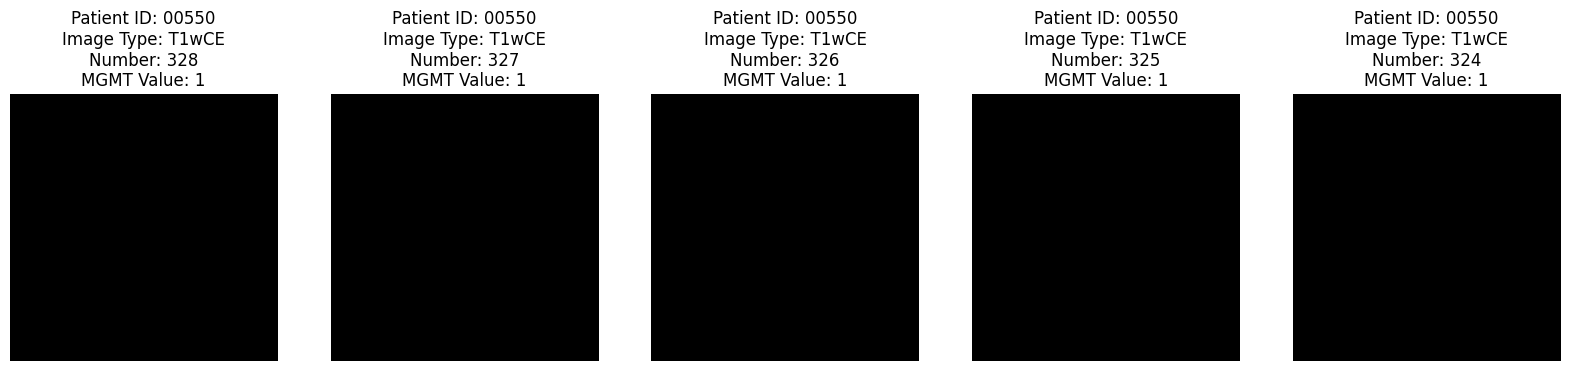

In [5]:
import os
import random
import matplotlib.pyplot as plt

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Choose a random patient
random_patient_id = random.choice(list(highest_images.keys()))
# Choose a random image type for that patient
random_image_type = random.choice(list(highest_images[random_patient_id].keys()))

# Load the five highest numbered images for the chosen patient and image type
random_images_info = []
for highest_number in highest_images[random_patient_id][random_image_type]:
    img_path = os.path.join(dataset_dir, random_patient_id, random_image_type, f"Image-{highest_number}.dcm")
    img = load_dicom_image(img_path)
    if img is not None:
        random_images_info.append((img, random_patient_id, random_image_type, highest_number))

# Get MGMT value
mgm_value = patient_mgm_mapping.get(random_patient_id, "N/A")

# Display the images
plt.figure(figsize=(20, 4))
for i, (img, patient_id, image_type, highest_number) in enumerate(random_images_info):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Patient ID: {patient_id}\nImage Type: {image_type}\nNumber: {highest_number}\nMGMT Value: {mgm_value}")
    plt.axis('off')
plt.show()


# Printing all 5 images from 4 types from patient id's

/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


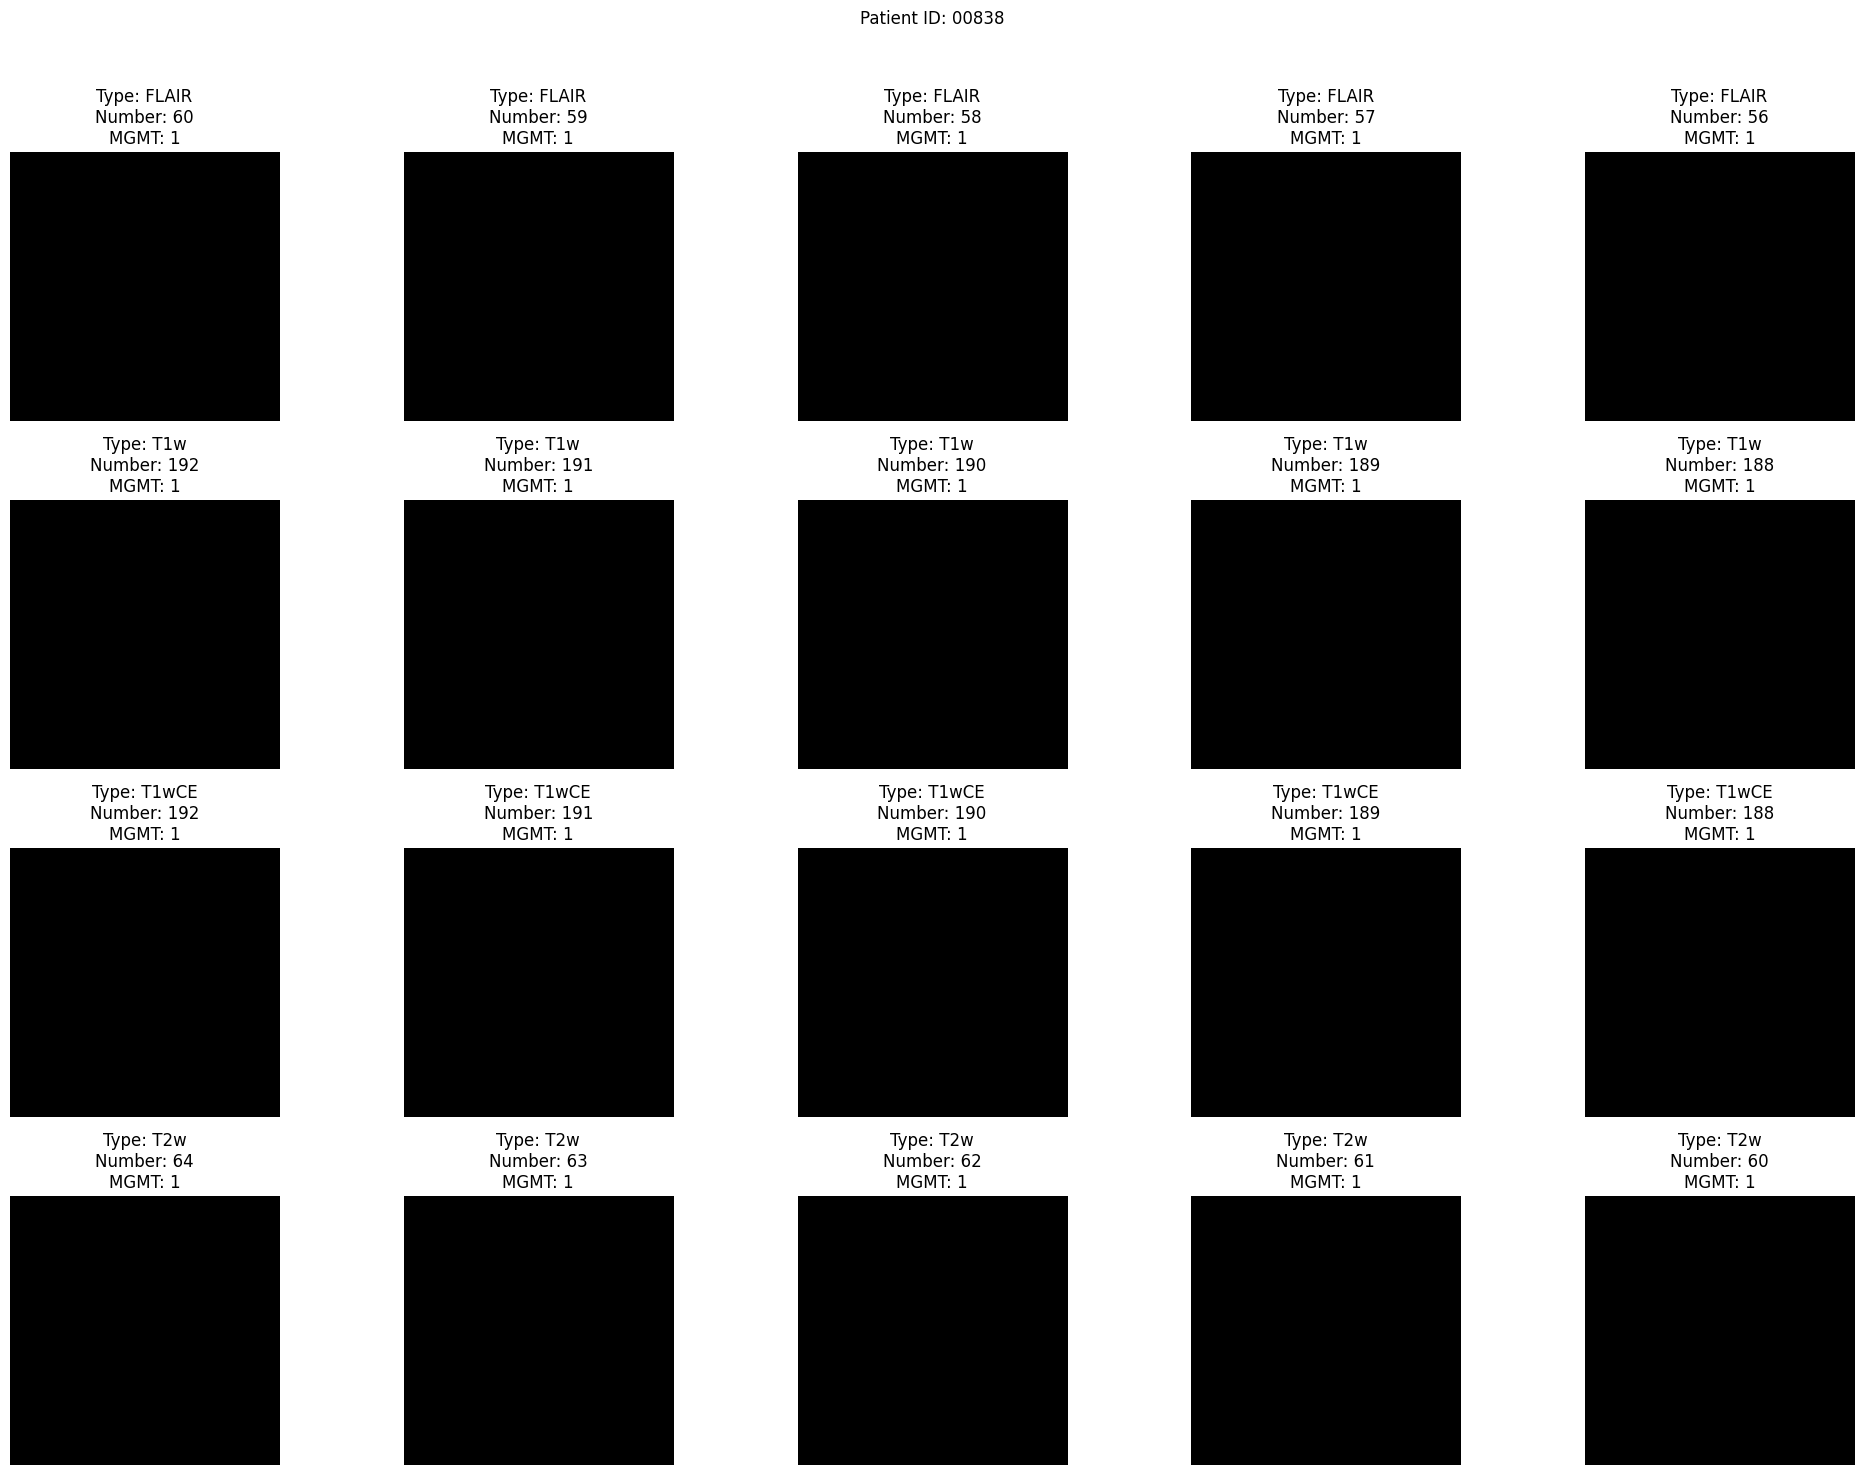

In [6]:
import os
import random
import matplotlib.pyplot as plt

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Choose a random patient for visualization
random_patient_id = random.choice(list(highest_images.keys()))

# Get MGMT value for the selected patient
mgm_value = patient_mgm_mapping.get(random_patient_id, "N/A")

# Get the highest numbered images for the selected patient
image_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
images = {image_type: [] for image_type in image_types}

for image_type in image_types:
    highest_numbers = highest_images[random_patient_id].get(image_type, [])
    for highest_number in highest_numbers:
        img_path = os.path.join(dataset_dir, random_patient_id, image_type, f"Image-{highest_number}.dcm")
        img = load_dicom_image(img_path)
        if img is not None:
            images[image_type].append((img, highest_number, img_path))

# Display the images
plt.figure(figsize=(20, 15))

for row, image_type in enumerate(image_types):
    for col, (img, highest_number, img_path) in enumerate(images[image_type]):
        plt.subplot(4, 5, row * 5 + col + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Type: {image_type}\nNumber: {highest_number}\nMGMT: {mgm_value}")
        plt.axis('off')

plt.suptitle(f"Patient ID: {random_patient_id}")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Data augumentation

/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/1612031744.py:14: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


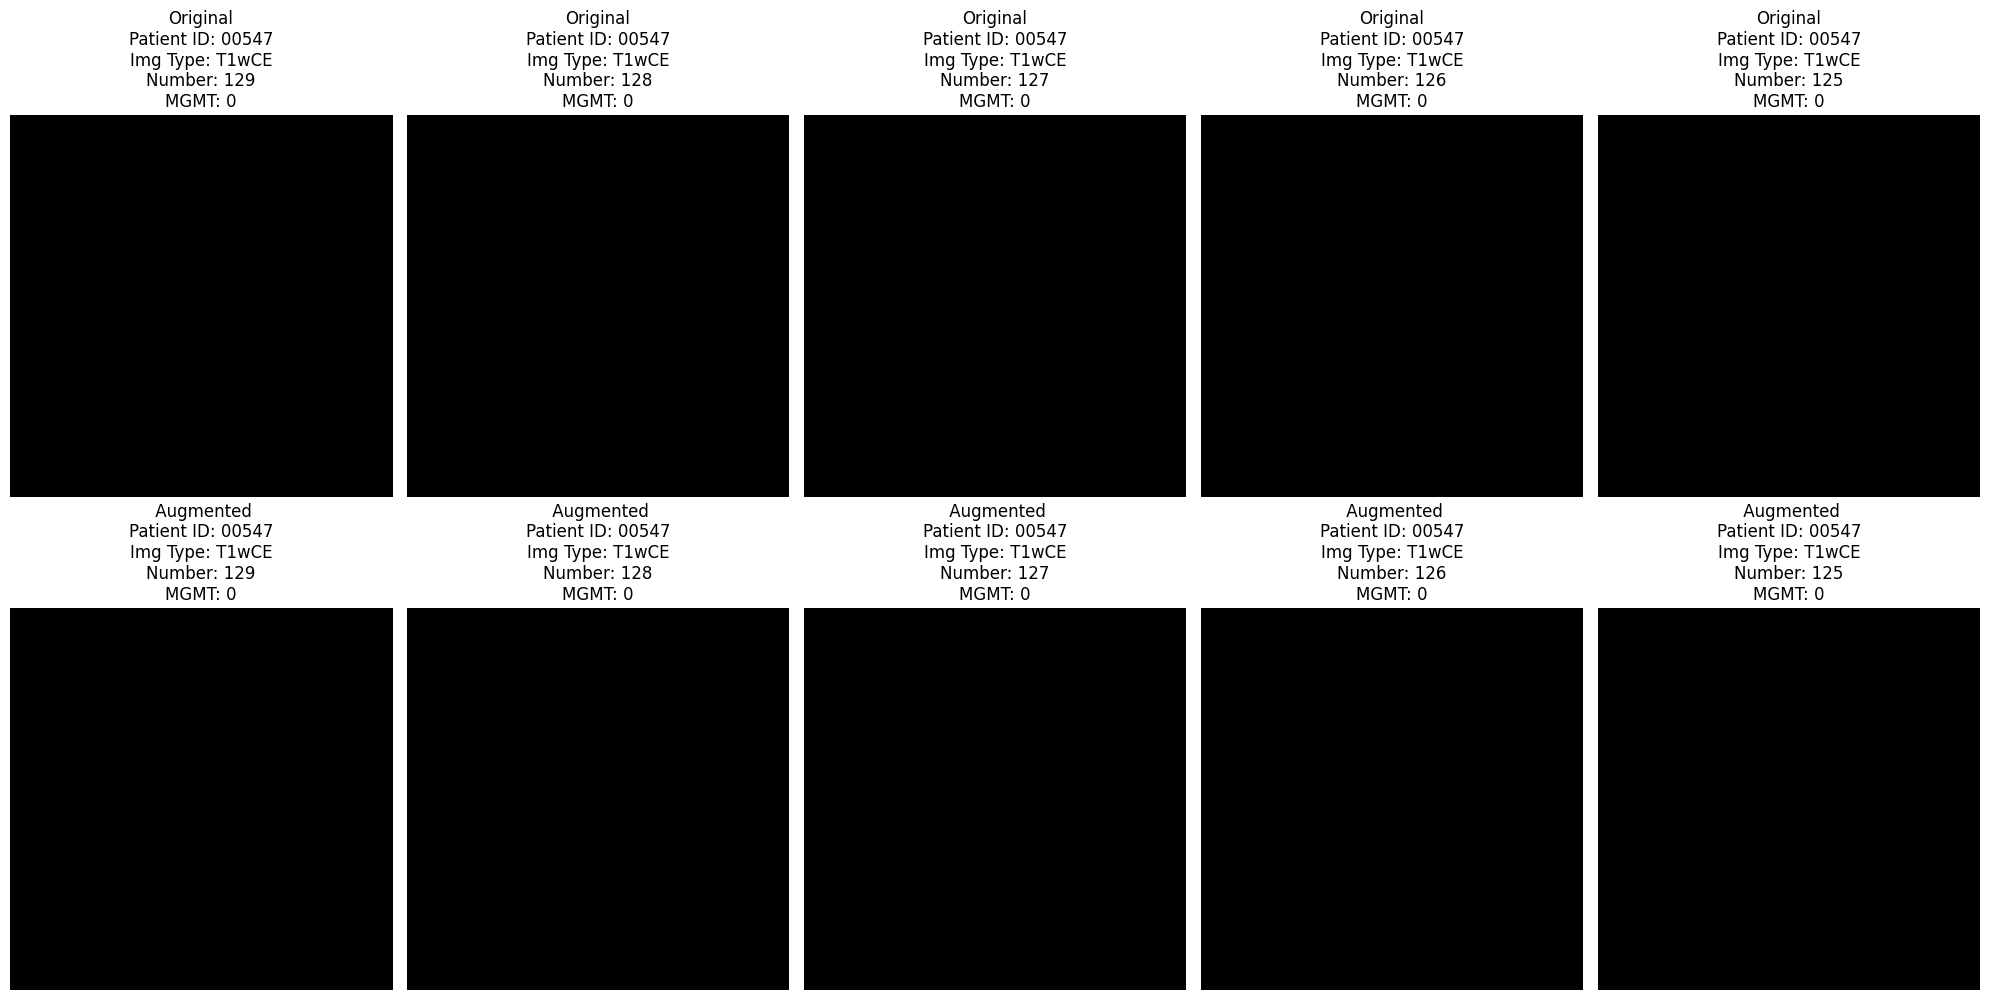

In [7]:
import os
import random
import matplotlib.pyplot as plt
import albumentations as A

# Data augmentation function
def augment_image(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.CLAHE(p=0.5),
        A.RandomGamma(p=0.5)
    ])
    augmented = aug(image=image)
    return augmented['image']

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Choose a random patient
random_patient_id = random.choice(list(highest_images.keys()))
# Choose a random image type for that patient
random_image_type = random.choice(list(highest_images[random_patient_id].keys()))

# Load the five highest numbered images for the chosen patient and image type
random_images_info = []
for highest_number in highest_images[random_patient_id][random_image_type]:
    img_path = os.path.join(dataset_dir, random_patient_id, random_image_type, f"Image-{highest_number}.dcm")
    img = load_dicom_image(img_path)
    if img is not None:
        random_images_info.append((img, random_patient_id, random_image_type, highest_number))

# Get MGMT value
mgm_value = patient_mgm_mapping.get(random_patient_id, "N/A")

# Display the original and augmented images
plt.figure(figsize=(20, 10))
for i, (img, patient_id, image_type, highest_number) in enumerate(random_images_info):
    # Augment the image
    augmented_img = augment_image(img)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\nPatient ID: {patient_id}\nImg Type: {image_type}\nNumber: {highest_number}\nMGMT: {mgm_value}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_img, cmap='gray')
    plt.title(f"\n \n Augmented\nPatient ID: {patient_id}\nImg Type: {image_type}\nNumber: {highest_number}\nMGMT: {mgm_value}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Model building

Explanation: Data Preprocessing:

The images are resized to 224x224 pixels and normalized. The highest-numbered DICOM images for each patient are loaded and preprocessed. Data Augmentation:

To enhance model generalization, data augmentation techniques like horizontal/vertical flips, rotations, and shifts are applied using ImageDataGenerator. Transfer Learning:

A pre-trained ResNet50 model is used as the base model. Additional fully connected layers are added on top of ResNet50 for binary classification (MGMT promoter methylation status). Initially, the layers of ResNet50 are frozen, and only the newly added layers are trained. Model Training and Fine-Tuning:

The model is trained with the augmented data for a few epochs. Then, the last 50 layers of ResNet50 are unfrozen for fine-tuning to further improve performance. Evaluation:

The model's accuracy on the validation set is calculated and printed. Model Saving:

The trained model is saved for future use. This approach leverages the power of transfer learning to achieve high accuracy with relatively few epochs of training. The data augmentation techniques help in improving the model's robustness and generalization.

In [8]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd

def load_dicom_image(filepath):
    """Load a DICOM image, resize it to 256x256 pixels, and normalize its intensity."""
    try:
        ds = pydicom.dcmread(filepath)
        if hasattr(ds, 'pixel_array'):
            img = ds.pixel_array
            img = cv2.resize(img, (256, 256))
            img = (img / np.max(img) * 255).astype(np.uint8)
            return img
        else:
            print(f"No pixel_array attribute found for {filepath}")
            return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def load_images(highest_images, dataset_dir, patient_mgm_mapping):
    """Load the highest numbered images and their corresponding labels."""
    images = []
    labels = []

    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_numbers_list in highest_numbers.items():
            for highest_number in highest_numbers_list:
                image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
                if os.path.exists(image_path):
                    img = load_dicom_image(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(patient_mgm_mapping.get(patient_id, 0))  # Default to 0 if not found
                else:
                    print(f"Image path does not exist: {image_path}")

    return np.array(images), np.array(labels)

# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
# Debug highest_images content
print("Example entry from highest_images:", next(iter(highest_images.items())))

X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Print information about the loaded data
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)



Example entry from highest_images: ('00688', {'FLAIR': [196, 195, 194, 193, 192], 'T1w': [214, 213, 212, 211, 210], 'T1wCE': [214, 213, 212, 211, 210], 'T2w': [376, 375, 374, 373, 372]})


/tmp/ipykernel_18/1732477633.py:14: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/1732477633.py:14: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


Shape of X (images): (11700, 256, 256)
Shape of y (labels): (11700,)


In [9]:
from sklearn.model_selection import train_test_split

# Data loading and preprocessing
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipykernel_18/1732477633.py:14: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/1732477633.py:14: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


In [10]:
import numpy as np

# Assuming you have loaded your dataset into variables X_train and y_train

# Number of classes
num_classes = len(np.unique(y_train))

# Size of the dataset
total_samples = len(X_train)
samples_per_class = total_samples / num_classes

# Image dimensions
image_shape = X_train[0].shape

# Nature of the data
class_counts = {label: np.sum(y_train == label) for label in np.unique(y_train)}
max_count = max(class_counts.values())
min_count = min(class_counts.values())
class_balance_ratio = min_count / max_count

print("Number of Classes:", num_classes)
print("Total Samples:", total_samples)
print("Samples Per Class (on average):", samples_per_class)
print("Image Dimensions:", image_shape)
print("Class Balance Ratio:", class_balance_ratio)


Number of Classes: 2
Total Samples: 9360
Samples Per Class (on average): 4680.0
Image Dimensions: (256, 256)
Class Balance Ratio: 0.8874773139745916


In [11]:
import os
import pandas as pd
import numpy as np
import pydicom
import cv2

# Function to load a DICOM image and preprocess it
def load_dicom_image(filepath):
    """Load a DICOM image, resize it to 256x256 pixels, and normalize its intensity."""
    try:
        ds = pydicom.dcmread(filepath)
        if hasattr(ds, 'pixel_array'):
            img = ds.pixel_array
            img = cv2.resize(img, (256, 256))
            img = (img / np.max(img) * 255).astype(np.uint8)
            return img
        else:
            print(f"No pixel_array attribute found for {filepath}")
            return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Function to load test images from a directory
def load_test_images(test_dir, max_images_per_type=5):
    """Load test images from the specified directory."""
    test_images = []
    for patient_dir in os.listdir(test_dir):
        patient_path = os.path.join(test_dir, patient_dir)
        if os.path.isdir(patient_path):
            for image_type in os.listdir(patient_path):
                image_type_path = os.path.join(patient_path, image_type)
                if os.path.isdir(image_type_path):
                    #print(f"Loading images from directory: {image_type_path}")
                    image_files = [filename for filename in os.listdir(image_type_path) if filename.endswith('.dcm')]
                    image_files.sort(reverse=True)  # Sort files in descending order
                    for filename in image_files[:max_images_per_type]:
                        filepath = os.path.join(image_type_path, filename)
                        img = load_dicom_image(filepath)
                        if img is not None:
                            test_images.append(img)
                        else:
                            print(f"Failed to load image: {filepath}")
    return np.array(test_images)



# Load test images
test_dir = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test'
X_test = load_test_images(test_dir)

print("Number of images loaded:", len(X_test))

# Load sample submissions CSV file to get the labels
sample_submissions_file = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv'
sample_submissions_df = pd.read_csv(sample_submissions_file)

# Extract the labels from the CSV file
y_test = sample_submissions_df['MGMT_value'].values

# Print information about the loaded test data
print("Shape of X_test (test images):", X_test.shape)
print("Length of y_test (labels):", len(y_test))


/tmp/ipykernel_18/2286877882.py:15: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)
/tmp/ipykernel_18/2286877882.py:15: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)


Number of images loaded: 1740
Shape of X_test (test images): (1740, 256, 256)
Length of y_test (labels): 87


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,786 (56.64 MB)

 Trainable params: 14,846,786 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,  # Assuming you have your training data loaded into X_train and y_train
    validation_data=(X_val, y_val),  # Assuming you have your validation data loaded into X_val and y_val
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 864s 3s/step - accuracy: 0.5388 - loss: 1.1997 - val_accuracy: 0.5299 - val_loss: 0.6928
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 831s 3s/step - accuracy: 0.5691 - loss: 0.6743 - val_accuracy: 0.5372 - val_loss: 0.6871
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.5956 - loss: 0.6366 - val_accuracy: 0.5462 - val_loss: 0.6879
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 855s 3s/step - accuracy: 0.6116 - loss: 0.6051 - val_accuracy: 0.5402 - val_loss: 0.7171
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 831s 3s/step - accuracy: 0.6247 - loss: 0.5743 - val_accuracy: 0.5432 - val_loss: 0.7888
Epoch 6/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 860s 3s/step - accuracy: 0.6198 - loss: 0.5727 - val_accuracy: 0.5474 - val_loss: 0.7742
Epoch 7/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - accuracy: 0.6272 - loss: 0.5736 - val_accuracy: 0.5462 - val_loss: 0.8224
Epoch 8/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - accuracy: 0.6276 - loss: 0.5650 - val_accu

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Bidirectional, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the CNN model within a custom Layer
class CustomCNNLayer(Layer):
    def __init__(self):
        super(CustomCNNLayer, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D((2, 2))
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2))
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2))
        self.bn3 = BatchNormalization()
        self.gap = GlobalAveragePooling2D()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.gap(x)
        return x
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 128)



# Define the CNN-LSTM model
def create_model(input_shape):
    cnn_layer = CustomCNNLayer()
    
    # LSTM layers
    lstm_input = Input(shape=input_shape)
    time_distributed_cnn = TimeDistributed(cnn_layer)(lstm_input)
    lstm_out = Bidirectional(LSTM(64))(time_distributed_cnn)
    
    # Fully connected layers
    x = Dense(128, activation='relu')(lstm_out)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


# Assuming X_train and X_val are already loaded and preprocessed

# Reshape data for LSTM (assuming we have 5 images per sequence)
n_sequences_train = X_train.shape[0] // 5
X_train_lstm = X_train.reshape(n_sequences_train, 5, 256, 256, 1)
y_train_lstm = np.repeat(y_train, n_sequences_train * 5)  # Repeat each label for each sequence

n_sequences_val = X_val.shape[0] // 5
X_val_lstm = X_val.reshape(n_sequences_val, 5, 256, 256, 1)
y_val_lstm = np.repeat(y_val, n_sequences_val * 5)  # Repeat each label for each sequence


print("\nShapes after reshaping for LSTM:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Create and compile the model
input_shape = (5, 256, 256, 1)
model = create_model(input_shape)
model.summary()


# Train the model
batch_size = 16
epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)



print("X_train_lstm shape:", X_train_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("y_val_lstm shape:", y_val_lstm.shape)


print("Shapes after loading images:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Data loading and preprocessing
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


print("\nShapes after train-test split:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Reshape data for LSTM (assuming we have 5 images per sequence)
n_sequences = X_train.shape[0] // 5
X_train_lstm = X_train.reshape(n_sequences, 5, 256, 256, 1)
y_train_lstm = np.repeat(y_train, 5, axis=0)[:n_sequences * 5]

n_sequences_val = X_val.shape[0] // 5
X_val_lstm = X_val.reshape(n_sequences_val, 5, 256, 256, 1)
y_val_lstm = np.repeat(y_val, 5, axis=0)[:n_sequences_val * 5]


print("\nShapes after reshaping for LSTM:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Reshape data for LSTM (assuming we have 5 images per sequence)
n_sequences = X_train.shape[0] // 5
X_train_lstm = X_train.reshape(n_sequences, 5, 256, 256, 1)
y_train_lstm = np.repeat(y_train, n_sequences * 5)  # Repeat each label for each sequence

n_sequences_val = X_val.shape[0] // 5
X_val_lstm = X_val.reshape(n_sequences_val, 5, 256, 256, 1)
y_val_lstm = np.repeat(y_val, n_sequences_val * 5)  # Repeat each label for each sequence

print("\nShapes after reshaping for LSTM:")
print("X_train_lstm shape:", X_train_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("y_val_lstm shape:", y_val_lstm.shape)





print("n_sequences:", n_sequences)
print("n_sequences_val:", n_sequences_val)


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create model
input_shape = (5, 256, 256, 1)
model = create_model(input_shape)
model.summary()

# Training the model
batch_size = 16
epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    datagen.flow(X_train_lstm, y_train_lstm, batch_size=batch_size),
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_lstm, y_val_lstm, verbose=0)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Bidirectional, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the CNN model within a custom Layer
class CustomCNNLayer(Layer):
    def __init__(self):
        super(CustomCNNLayer, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D((2, 2))
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2))
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2))
        self.bn3 = BatchNormalization()
        self.gap = GlobalAveragePooling2D()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.gap(x)
        return x
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 128)

# Define the CNN-LSTM model
def create_model(input_shape):
    cnn_layer = CustomCNNLayer()
    
    # LSTM layers
    lstm_input = Input(shape=input_shape)
    time_distributed_cnn = TimeDistributed(cnn_layer)(lstm_input)
    lstm_out = Bidirectional(LSTM(64))(time_distributed_cnn)
    
    # Fully connected layers
    x = Dense(128, activation='relu')(lstm_out)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

print("Shapes after loading images:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nShapes after train-test split:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

n_sequences = X_train.shape[0] // 5

# Reshape data for LSTM (assuming we have 5 images per sequence)
X_train = X_train.reshape(n_sequences * 5, 256, 256, 1)
y_train = np.repeat(y_train, 5, axis=0)  # Repeat each label 5 times to match X_train
y_train = y_train[:n_sequences * 5]  # Ensure length matches X_train

n_sequences_val = X_val.shape[0] // 5
X_val = X_val.reshape(n_sequences_val * 5, 256, 256, 1)
y_val = np.repeat(y_val, 5, axis=0)  # Repeat each label 5 times to match X_val
y_val = y_val[:n_sequences_val * 5]  # Ensure length matches X_val


print("\nShapes after reshaping for LSTM:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


# Reshape data for LSTM (assuming we have 5 images per sequence)
X_train = X_train.reshape(-1, 5, 256, 256, 1)
X_val = X_val.reshape(-1, 5, 256, 256, 1)

print("\nFinal shapes for LSTM input:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# Create model
input_shape = (5, 256, 256, 1)
model = create_model(input_shape)
model.summary()

# Training the model
batch_size = 16
epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")



# Revised Code with Transfer Learning and Enhanced Training Strategy

import os
import numpy as np
import pydicom
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Function to load DICOM image
def load_dicom_image(filepath):
    try:
        ds = pydicom.dcmread(filepath)
        if hasattr(ds, 'pixel_array'):
            img = ds.pixel_array
            img = cv2.resize(img, (256, 256))
            img = (img / np.max(img) * 255).astype(np.uint8)
            return img
        else:
            return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Data Augmentation function
def augment_image(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.CLAHE(p=0.5),
        A.RandomGamma(p=0.5)
    ])
    augmented = aug(image=image)
    return augmented['image']

# Load and store paths of highest numbered images for each patient
def find_highest_numbered_image(patient_dir):
    image_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    highest_numbers = {}
    for image_type in image_types:
        image_files = []
        for root, dirs, files in os.walk(os.path.join(patient_dir, image_type)):
            for file in files:
                if file.endswith(".dcm"):
                    try:
                        image_number = int(file.split('.')[0].split('-')[1])
                        image_files.append(image_number)
                    except Exception as e:
                        print(f"Error processing file {file}: {e}")
        if image_files:
            highest_numbers[image_type] = sorted(image_files, reverse=True)[:5]
    return highest_numbers

def load_and_store_highest_images(dataset_dir):
    highest_images = {}
    for patient_dir in os.listdir(dataset_dir):
        patient_id = patient_dir
        patient_path = os.path.join(dataset_dir, patient_dir)
        highest_numbers = find_highest_numbered_image(patient_path)
        if highest_numbers:
            highest_images[patient_id] = highest_numbers
    return highest_images

def load_highest_images(highest_images, dataset_dir):
    images = []
    labels = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_numbers_list in highest_numbers.items():
            for highest_number in highest_numbers_list:
                image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
                if os.path.exists(image_path):
                    img = load_dicom_image(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(patient_mgm_mapping.get(patient_id, 0))  # Default to 0 if not found
    return np.array(images), np.array(labels)

def map_patient_id_to_mgm_value(highest_images, labels_df):
    patient_mgm_mapping = {}
    for patient_id in highest_images:
        mgm_value = labels_df.loc[labels_df['BraTS21ID'] == int(patient_id), 'MGMT_value'].values
        if len(mgm_value) > 0:
            patient_mgm_mapping[patient_id] = mgm_value[0]
    return patient_mgm_mapping

# Define dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load train_labels.csv
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Load highest numbered images
X, y = load_highest_images(highest_images, dataset_dir)

# Augment images
augmented_images = [augment_image(img) for img in X]
X = np.array(augmented_images)

# Normalize images
X = X / 255.0
X = np.expand_dims(X, axis=-1)  # Expand dimensions to fit model input

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Use ResNet50 for Transfer Learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
val_accuracy = model.evaluate(X_val, y_val)[1]
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


# tdd cnn lstm

import os
import cv2
import numpy as np
import pandas as pd

# Load and preprocess images
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def load_dicom_image(image_path):
    # Assuming pydicom is used to read DICOM files
    import pydicom
    dicom = pydicom.dcmread(image_path)
    img = dicom.pixel_array
    img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
    return img

# Load the highest numbered images for each patient and preprocess them
def load_images(highest_images, dataset_dir, patient_mgm_mapping):
    images = []
    labels = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_number in highest_numbers.items():
            image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
            if os.path.exists(image_path):
                img = load_dicom_image(image_path)
                if img is not None:
                    img = preprocess_image(img)
                    images.append(img)
                    labels.append(patient_mgm_mapping[patient_id])
    return np.array(images), np.array(labels)

# Load and preprocess the images
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Print information about the loaded data
print("Number of images:", len(X))
print("Number of labels:", len(y))
print("Shape of a single image:", X[0].shape)


# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Print information about the loaded data
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)


import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, LSTM, Flatten, Dense
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and preprocess images
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def load_dicom_image(image_path):
    # Assuming pydicom is used to read DICOM files
    import pydicom
    dicom = pydicom.dcmread(image_path)
    img = dicom.pixel_array
    img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
    return img

# Load the highest numbered images for each patient and preprocess them
def load_images(highest_images, dataset_dir, patient_mgm_mapping):
    images = []
    labels = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_number in highest_numbers.items():
            image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
            if os.path.exists(image_path):
                img = load_dicom_image(image_path)
                if img is not None:
                    img = preprocess_image(img)
                    images.append(img)
                    labels.append(patient_mgm_mapping[patient_id])
    return np.array(images), np.array(labels)

# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# For demonstration, I'm using placeholders for X and y. Replace these with your actual data loading logic.
#X, y = np.random.rand(100, 224, 224, 3), np.random.randint(0, 2, 100)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Add channel dimension and reshape for RGB images
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
X_val = np.expand_dims(X_val, axis=-1)  # Add channel dimension

# Now reshape to have 3 channels for RGB images
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)

# Define the TimeDistributed-CNN-LSTM model
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 224, 224, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(256),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val)
)


# cnn model

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

# Prepare the dataset
X = np.array([img for img, _, _, _ in loaded_images])
y = np.array([patient_mgm_mapping.get(patient_id) for _, patient_id, _, _ in loaded_images])

# Convert grayscale images to RGB by stacking the single channel to form three channels
X = np.stack([X] * 3, axis=-1)

# Normalize the images
X = X / 255.0

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model using transfer learning with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

# Prepare the dataset
X = np.array([img for img, _, _, _ in loaded_images])
y = np.array([patient_mgm_mapping.get(patient_id) for _, patient_id, _, _ in loaded_images])

# Convert grayscale images to RGB by stacking the single channel to form three channels
X = np.stack([X] * 3, axis=-1)

# Normalize the images
X = X / 255.0

# Assuming each MRI scan has multiple slices (time steps), reshape accordingly
# Let's assume each MRI scan has 20 slices
n_slices = 20
X = X.reshape(-1, n_slices, 256, 256, 3)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model using the TimeDistributed-CNN-LSTM approach
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

cnn_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D()
])

# Define the main model with TimeDistributed and LSTM layers
input_layer = layers.Input(shape=(n_slices, 256, 256, 3))
time_distributed_layer = layers.TimeDistributed(cnn_model)(input_layer)
lstm_layer = layers.LSTM(128)(time_distributed_layer)
dense_layer = layers.Dense(128, activation='relu')(lstm_layer)
dropout_layer = layers.Dropout(0.5)(dense_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Validate predictions on a few samples
predictions = model.predict(X_val[:10])
for i in range(10):
    plt.figure(figsize=(5, 5))
    plt.imshow(X_val[i])
    plt.title(f"True Label: {y_val[i]}, Predicted: {predictions[i][0]:.2f}")
    plt.axis('off')
    plt.show()
